# Florida Panthers Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [13]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [4]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [5]:
lkupclientid = 36 # flames

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrFlames].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38377 entries, 0 to 38376
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              38377 non-null  int64  
 1   dimCustomerMasterId       38377 non-null  int64  
 2   customerNumber            38377 non-null  object 
 3   year                      38377 non-null  object 
 4   productGrouping           38377 non-null  object 
 5   totalSpent                38377 non-null  float64
 6   recentDate                38377 non-null  object 
 7   attendancePercent         38377 non-null  float64
 8   renewedBeforeDays         38376 non-null  float64
 9   isBuyer                   38377 non-null  object 
 10  source_tenure             38377 non-null  int64  
 11  tenure                    38376 non-null  float64
 12  distToVenue               38377 non-null  float64
 13  totalGames                38377 non-null  int64  
 14  recenc

### Let's drop the features that have lots of null values:

In [6]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38377 entries, 0 to 38376
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          38377 non-null  int64  
 1   dimCustomerMasterId   38377 non-null  int64  
 2   customerNumber        38377 non-null  object 
 3   year                  38377 non-null  object 
 4   productGrouping       38377 non-null  object 
 5   totalSpent            38377 non-null  float64
 6   recentDate            38377 non-null  object 
 7   attendancePercent     38377 non-null  float64
 8   renewedBeforeDays     38376 non-null  float64
 9   isBuyer               38377 non-null  object 
 10  source_tenure         38377 non-null  int64  
 11  tenure                38376 non-null  float64
 12  distToVenue           38377 non-null  float64
 13  totalGames            38377 non-null  int64  
 14  recency               38377 non-null  int64  
 15  missed_games_1     

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [7]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (34539, 47)
Unseen Data For Predictions: (3838, 47)
Data for Modeling (A Class): (34539, 47)
Unseen Data For Predictions: (3838, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [8]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(38377, 29)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [9]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38377 entries, 0 to 38376
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  38377 non-null  int64  
 1   attendancePercent    38377 non-null  float64
 2   renewedBeforeDays    38376 non-null  float64
 3   source_tenure        38377 non-null  int64  
 4   tenure               38376 non-null  float64
 5   totalGames           38377 non-null  int64  
 6   missed_games_1       38377 non-null  int64  
 7   missed_games_2       38377 non-null  int64  
 8   missed_games_over_2  38377 non-null  int64  
 9   resale_atp           38377 non-null  float64
 10  isNextYear_Buyer     38377 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.2 MB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [10]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,missed_games_1,missed_games_2,missed_games_over_2,resale_atp,isNextYear_Buyer
dimCustomerMasterId,1.00,-0.05,0.12,0.11,0.13,0.10,0.06,0.02,0.00,-0.01,0.08
attendancePercent,-0.05,1.00,0.33,0.03,-0.61,0.68,0.28,0.04,-0.07,0.05,0.47
renewedBeforeDays,0.12,0.33,1.00,0.33,-0.12,0.68,0.42,0.19,0.10,0.04,0.30
source_tenure,0.11,0.03,0.33,1.00,0.19,0.23,0.10,0.02,-0.01,-0.01,0.15
tenure,0.13,-0.61,-0.12,0.19,1.00,-0.35,-0.18,-0.07,-0.05,-0.03,-0.49
totalGames,0.10,0.68,0.68,0.23,-0.35,1.00,0.52,0.18,0.04,0.09,0.61
missed_games_1,0.06,0.28,0.42,0.10,-0.18,0.52,1.00,0.33,0.20,0.06,0.30
missed_games_2,0.02,0.04,0.19,0.02,-0.07,0.18,0.33,1.00,0.33,0.02,0.12
missed_games_over_2,0.00,-0.07,0.10,-0.01,-0.05,0.04,0.20,0.33,1.00,0.02,0.05
resale_atp,-0.01,0.05,0.04,-0.01,-0.03,0.09,0.06,0.02,0.02,1.00,0.06


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [11]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (30702, 11)
Unseen Data For Predictions: (7675, 11)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [17]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,1342
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(30702, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['attendancePercent',
                                                           'source_tenure',
                                                           'tenure',
                                                           'totalGames',
                                                           'missed_games_1',
                                                           'missed_games_2',
                                                           'missed_games_over_2'],
                                       target='isNextYear_Buyer',
                                       time_features=[])),
                 ('impu

In [18]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.9423,0.9837,0.9703,0.9375,0.9536,0.8775,0.8785,0.0800
9,Extreme Gradient Boosting,0.9410,0.9833,0.9667,0.9386,0.9524,0.8750,0.8757,0.7420
7,Random Forest Classifier,0.9400,0.9819,0.9667,0.9370,0.9516,0.8727,0.8735,0.5290
2,Gradient Boosting Classifier,0.9389,0.9820,0.9715,0.9315,0.9510,0.8699,0.8714,0.4910
3,Extra Trees Classifier,0.9381,0.9781,0.9690,0.9324,0.9503,0.8684,0.8696,0.4240
0,Ada Boost Classifier,0.9296,0.9795,0.9684,0.9206,0.9438,0.8498,0.8519,0.1510
8,NGBClassifier,0.9257,0.9795,0.9759,0.9091,0.9413,0.8403,0.8443,6.5660
1,Decision Tree Classifier,0.9162,0.9126,0.9290,0.9335,0.9312,0.8240,0.8241,0.0260
4,K Neighbors Classifier,0.8441,0.9073,0.9158,0.8426,0.8776,0.6639,0.6684,0.0760
6,Logistic Regression,0.6105,0.5442,1.0000,0.6105,0.7582,0.0000,0.0000,0.0170


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [19]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9377,0.9828,0.9707,0.9304,0.9501,0.8674,0.8688
1,0.9426,0.9856,0.9760,0.9331,0.9541,0.8777,0.8792
2,0.9430,0.9831,0.9713,0.9376,0.9542,0.8789,0.8798
3,0.9365,0.9832,0.9727,0.9269,0.9493,0.8645,0.8663
4,0.9406,0.9837,0.9713,0.9340,0.9523,0.8735,0.8747
5,0.9454,0.9825,0.9740,0.9389,0.9561,0.8841,0.8851
6,0.9524,0.9873,0.9760,0.9475,0.9616,0.8990,0.8997
7,0.9349,0.9807,0.9573,0.9373,0.9472,0.8622,0.8625
8,0.9507,0.9875,0.9640,0.9557,0.9598,0.8962,0.8962
9,0.9397,0.9809,0.9700,0.9338,0.9516,0.8719,0.8730


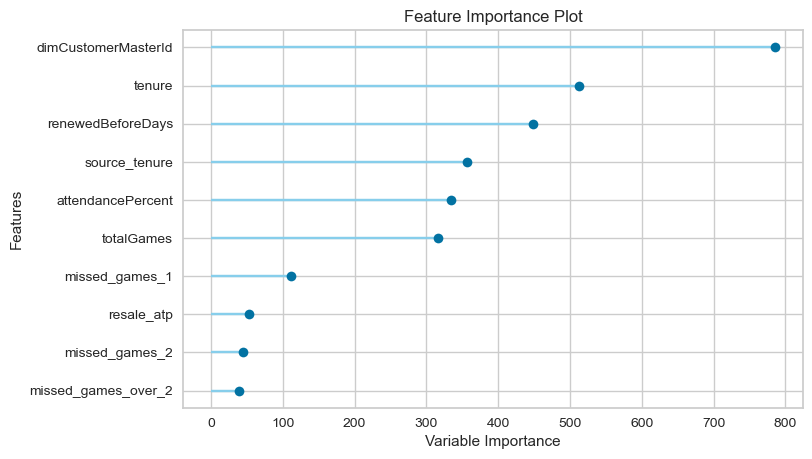

In [20]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?